# carry trade in cryptocurrency space

I investigate if the simple carry trade strategy is implementable in the cryptocurrency space and provide instructions and fully replicable code to replicate my findings; using data from the Kraken exchange, I show that sorting cryptocurrencies on the analogue of the fiat interest rate results in a statistically and economically meaningful excess returns and Sharpe ratios; my finding thus adds another asset to the universe of those where the carry trade anomaly is pronounced.

- [introduction](#introduction)
- [assumptions](#assumptions)
- [carry?](#carry?)
- [how/what to trade](#how/what-to-trade)
- [return calculation](#return-calculation)
    - [long](#long)
    - [short](#short)
    - [long-short](#long-short)
- [results](#results)
    - [imports and parameters](#imports-and-parameters)
    - [data](#data)
        - [spot price](#spot-price)
        - [perpetual futures price](#perpetual-futures-price)
        - [funding rates](#funding-rates)
    - [carry](#carry)
    - [portfolio construction](#portfolio-construction)
    - [excess returns](#excess-returns)
    - [carry trade performance](#carry-trade-performance)

## introduction
Cryptocurrencies are quite rapidly becoming a fully-fledged investable asset. One can debate about the lack of fundamental value, questionable incentives of issuers and end users, uncertain regulatory future etc. &mdash; but as long as there is supply and demand, an open market, derivative products and sufficient liquidity, Bitcoin and its peers are just as assety as stocks, bonds and commodity products.

Existence of a derivatives market, specifically futures, calls forth the concept of carry and provides a way to quantify it. In this short piece, I am using perpetual swaps, funding rates and spot prices from the cryptocurrency exchange Kraken to construct a simple long-short carry trade strategy on the set of five most liquid cryprocurrencies and investigate its properties. 

## literature
As of the latest commit, the only relevant work on the same topic is ["Crypto Carry"](https://dx.doi.org/10.2139/ssrn.3774118), which documents return predictability of the funding rate in the cross-section of 51 coins listed on the Huobi Exchange and a Sharpe ratio of the corresponding long-short strategy of 1.21. However, the authors are silent about the methodology of return computations. Our contribution &mdash; without pretending to be original &mdash; is to provide a fully transparent and replicable open source research on the existence of carry trade on the cryptocurrency markets.

## assumptions
1. USD is the currency of consumption;
1. trading takes place on Kraken;
1. investors can trade at mid prices;
1. investors do not move the market;
1. costs of setting up a crypto wallet and depositing/withdrawing liquidity are zero;
1. spot selling is at zero additional cost in terms of money and time.

Assumptions 1-3 are boring; assumption 4 is violated the more, the **larger** the trading volume [*TODO: references about trade sizes?*], and assumption 5 is violated the more, the **smaller** the trading volume; assumption 6 is violated regardless.

With these assumptions in place, I can answer the question whether the carry trade is there but not whether it is certainly economically profitable to execute. Still fun.

## carry?
"Carry trade" is a strategy for an investor who hopes that the spot price does not move over the investment horizon. It is constructed by taking long forward positions in assets with high, and short &mdash; in those with low "carry". The "carry" is the difference between the currently observed spot and futures prices (expressed as a percentage of the former), and is related to the opportunity costs and the costs of holding ("carrying") the asset. In the case of the cryptocurrency perpetual contracts, the funding rate is a related concept, and we will be using it instead of the very noisy price difference for the signal construction and subsequent sorting purposes. More about the funding rates follows.

## how/what to trade
The most liquid contracts to implement strategies with are the so-called [perpetual futures](https://support.kraken.com/hc/en-us/articles/360022835911-Inverse-crypto-collateral-perpetual-contract-specifications): these can be thought of as 4-hour swaps that are automatically rolled over earning what is called the [funding rate](https://blog.kraken.com/post/3075/quick-primer-on-funding-rates/https://blog.kraken.com/post/3075/quick-primer-on-funding-rates/). The latter is not dissimilar to the interest earned by the holder of a long ForEx position: longs pay shorts a certain amount which is determined based on the difference between the recent futures and spot prices (remember the carry concept?). If the futures has been traded too high relative to the spot, the funding rate becomes high also, incentivising market participants to take short positions (to be able to earn this high rate) and thus driving the futures price back down. 

Probably because financial intermediaries shun away from clearing  transactions involving fiat and cryptocurrencies, there are no familiar analogues to USDRUB, AUDUSD etc; it is not common to put USD as collateral to trade futures and realize PnL in dollars. Two alternatives exist: linear futures with stablecoins as the counter currency (such as Binance futures on ETHUSDT) and inverse futures margined in cryptocurrency (such as Kraken futures on ETHUSD). 

The former are the more familiar contracts as far as the specifications and PnL calculation are concerned, but require to purchase the countercurrency coins first, such as the Tether (USDT) or USD coin (USDC) -- two of the so-called stablecoins. A standard trade would go as follows:
1. buy USDT for USD on the spot market;
1. use USDT in the margin account to collateralize a position in ETHUSDT, BTCUSDT etc.;
1. realize PnL in USDT;
1. sell USDT for USD to consume.

An obvious disadvantage is the additional USD-USDT risk.

Inverse crypto-collateral futures are essentialy linear futures on the inverse of the pair. They seem to be more cost-efficient and do not involved a third currency, but contain implicit leverage for an investor with consumption denominated in the fiat currency (details later). A standard trade would go as follows:
1. buy the contract margin cryptocurrency for USD on the spot market;
1. use it to collateralize a position in the futures on the same cryptocurrency;
1. realize PnL in the cryptocurrency;
1. sell the cryptocurrency for USD to consume.

In what follows, I will use the inverse futures.

## return calculation
I use the following conventions:

* $S$ : spot exchange rate, denominated in USD;
* $F$ : futures rate, denominated in USD;
* $q$ : absolute funding rate, in coins per contract;
* $N_i$ : number of contracts of side $i, i \in (l, s)$ for (long, short);
* $r$ : net return, in fractions of 1, such as 0.1 for 10%

At time $t$ we start with 1 USD. Since the contracts are coin-margined, we need to convert this 1 USD into coins at rate $S_t$ and use it as collateral for all positions we will open. On most exchanges one contract is worth 1 USD and hence represents $\frac{1}{F_t}$ coins at inception.

**Note that in the empyrical part of this piece we do not reinvest the proceeds, starting each period with 1 dollar to collateralize the positions.**

### long

Being long $N_l$ inverse futures at rate $F_t$ is essentially being short USD at rate $\frac{1}{F_t}$, hence the payoff at time $t+1$ is $\left( \frac{1}{F_t} - \frac{1}{F_{t+1}} \right)$ coins. So, at $t+1$ we have a total of $N_l \left( \frac{1}{F_t} - \frac{1}{F_{t+1}}\right)$ coins in trading profit plus $\frac{1}{S_t}$ coins in the collateral account, all of which can be converted back at the prevailing rate for the total USD profit of:
\begin{equation*}
    N_l \left( \frac{1}{F_t} - \frac{1}{F_{t+1}}\right)S_{t+1} + \frac{S_{t+1}}{S_t}.
\end{equation*}
Now, assuming that $S \approx F$ and using $r = \frac{S_{t+1}}{S_t} - 1$, the above amount is equal to:
\begin{equation}
    1 + r(N_l + 1)
    \label{gross_ret_simplified}\tag{1}
\end{equation}
Since we started with 1 USD, this is also the gross return on our investment. Behold the implicit leverage: if we are long (the obvious minimum of) 1 contract, our return is twice the spot return! 

The final thing to take account of is the funding rate: being long, we pay the funding rate of $q_t$ coins per contract (note that this is the "absolute" funding rate, not the relative counterpart displayed at the front end of the exchanges). The exact gross return formula for a long position becomes:
\begin{equation}
    N_l \left( \frac{1}{F_t} - \frac{1}{F_{t+1}} - q_t \right) S_{t+1} + 
    \frac{S_{t+1}}{S_t}.
\end{equation}


### short

Being short $N_s$ inverse futures at rate $F_t$ is essentially being long USD at rate $\frac{1}{F_t}$. Similar considerations lead to the following equivalent of eq. [1](#mjx-eqn-gross_ret_simplified):
\begin{equation}
    1 + r(1 - N_s).
\end{equation}
Curiously, a zero-leverage short position of 1 contract *cannot grow or drop* in value in USD terms! If the coin price falls, we have more coins, which are worth less, and also the collateral account loses USD -- these forces cancel each other out. To be able to lose or earn USD, leverage is needed.

Before we proceed, here is the exact gross return formula for a short position:
\begin{equation}
    N_s \left( \frac{1}{F_{t+1}} - \frac{1}{F_t} + q_t \right) S_{t+1} + 
    \frac{S_{t+1}}{S_t}.
\end{equation}

### long-short


In a long-short portfolio, to make the long leg have the same leverage as the short, we can set $N_l=1$ and $N_s=3$, resulting in a multiplier of 2 on each. Since one contract is worth 1 USD, and we start with 1 USD in the collateral account, we have to open a total of 4 USD worth of contracts having 1 USD to collateralize them. Most exchanges would allow for much higher ratios.

As an example, imagine that the price of the coins in the long and short leg increases by 15\% and 5\% respectively: the portfolio return in this case (disregarding the tiny differences between $F$ and $S$ as well the funding rates) is $2(0.15 - 0.05)=20\%$.

## results

### imports and parameters

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter

from foolbox.econometrics.misc import descriptives
from foolbox.backtesting.sorting import rank_sort

from src.setup import *

from src.datafeed_.kraken.downstream import (get_funding_rates, 
                                             get_spot, 
                                             get_perpetual)

In [2]:
# pandas display settings
pd.set_option("display.precision", 2)

# parameters
t_hold = 1  # holding period, in multiples of a 4-hour period
ann = 365 * 6  # there are 6 4-hour periods per day
legsize = 2  # number of assets in the long and short leg of an HML portfolio
signal_lookback = 6 * 7  # 7 days lookback to compute carry signal

def format_dataframe(df_: pd.DataFrame, tail=True):
    """A little formatter helper."""
    if tail:
        return format_dataframe(df_.tail(), tail=False)
    if df_.columns.nlevels > 1:
        col_key = ("timestamp", "")
    else:
        col_key = "timestamp"
    res_ = df_.reset_index()\
        .style.format(formatter={col_key: lambda x: x.strftime("%Y-%m-%d %H:%M")})\
        .hide_index()
    return res_

### data
All data is from Kraken, snapped at 4 hour intervals starting at 00:00.

#### spot price
Let's take a look at the spot prices going through the roof.

In [3]:
# spot price
data_s = get_spot()\
    .resample("4H", closed="right", label="right").last()\
    .loc["2018-08":]
format_dataframe(data_s)

timestamp,bch,eth,ltc,xbt,xrp
2022-03-31 08:00,381.87,3404.50,129.52,47202.23,0.87
2022-03-31 12:00,382.35,3412.96,129.96,47166.40,0.87
2022-03-31 16:00,368.65,3347.79,124.11,46410.67,0.82
2022-03-31 20:00,377.34,3287.96,124.32,45596.26,0.81
2022-04-01 00:00,383.96,3281.08,123.69,45521.43,0.81


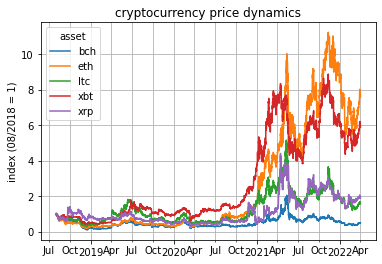

In [4]:
# plot spot price index
spot_idx = data_s.div(data_s.iloc[0], axis=1)
ax = sns.lineplot(data=spot_idx, dashes=False)

# formatting
ax.set_xticks(
    pd.period_range("2018-09", "2021-03", freq="6M").to_timestamp()
)
ax.xaxis.set_major_locator(YearLocator(1))
ax.xaxis.set_minor_locator(MonthLocator([4, 7, 10]))
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
ax.xaxis.set_minor_formatter(DateFormatter("%b"))

ax.grid(which="both")

ax.set_title("cryptocurrency price dynamics")

ax.set_ylabel("index (08/2018 = 1)")
ax.set_xlabel("", visible=False)

plt.show()

#### perpetual futures price

In [5]:
# load perpetual futures prices, reindex as the spot
data_p = get_perpetual(mid=True) \
    .resample("4H", closed="right", label="right").last()\
    .reindex_like(data_s)

format_dataframe(data_p)

timestamp,bch,eth,ltc,xbt,xrp
2022-03-31 08:00,380.88,3405.82,129.60,47194.78,0.87
2022-03-31 12:00,383.50,3409.05,129.88,47142.47,0.87
2022-03-31 16:00,369.19,3344.49,123.79,46440.47,0.82
2022-03-31 20:00,377.88,3289.74,124.44,45636.70,0.81
2022-04-01 00:00,385.14,3278.71,124.02,45508.26,0.81


Let's take a look at how close the perpetual is to the spot for the case of, say, XBT, zooming in on just one day.

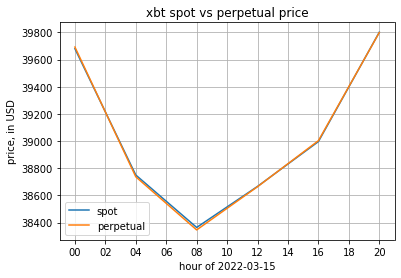

In [7]:
# take these for the example
c_ = "xbt"
d_ = "2022-03-15"

# plot two prices
to_plot = pd.concat((data_s[c_], data_p[c_]), axis=1, 
                    keys=["spot", "perpetual"])\
    .loc[d_]

ax = sns.lineplot(data=to_plot, dashes=False)

ax.xaxis.set_major_formatter(DateFormatter("%H"))

ax.grid(which="both")

ax.set_title(f"{c_} spot vs perpetual price")

ax.set_ylabel("price, in USD")
ax.set_xlabel(f"hour of {d_}", visible=True)

plt.show()

#### funding rates

In [8]:
# abs and relative funding rate
data_f = get_funding_rates()
format_dataframe(data_f)

index,timestamp,asset,which,rate
83655,2022-06-25 20:00,ltc,relative,-0.00
83656,2022-06-25 20:00,xbt,absolute,0.00
83657,2022-06-25 20:00,xbt,relative,0.00
83658,2022-06-25 20:00,xrp,absolute,-0.00
83659,2022-06-25 20:00,xrp,relative,-0.00


### carry

As mentioned before, the carry of a futures contract is the difference between the spot and futures prices, expressed as the percentage of the former. However, this measure is quite noisy at the 4-hour frequency, so for the signal construction purposes here we rely on a similar concept of the funding rate, which is nothing but a trimmed time-series average of the actual carry.

In [10]:
# carry is the negative of the relative funding rate, ~(spot / fwd - 1)
carry = data_f \
    .query("which == 'relative'").drop("which", axis=1) \
    .pivot(index="timestamp", columns="asset", values="rate")\
    .mul(-1)

Here is the spot/futures ratio less 1, also known as the forward discount, compared to the relative funding rate.

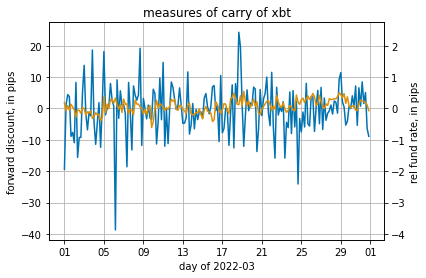

In [12]:
fwd_d = (data_s / data_p - 1)

c_ = "xbt"
m_ = "2022-03"

to_plot = pd.concat((fwd_d.loc[m_, c_], carry.loc[m_, c_]), 
                    axis=1, keys=["fwd-disc", "rel-fund"]) * 10000

# plot on two axes, style
ax = sns.lineplot(data=to_plot["fwd-disc"], color=sns.color_palette("colorblind")[0])
ax2 = ax.twinx()
sns.lineplot(data=to_plot["rel-fund"], color=sns.color_palette("colorblind")[1], ax=ax2)
ax2.set_ylim(np.array(ax.get_ylim()) / 10)
ax2.set_yticks(ax.get_yticks() / 10)
ax2.set_ylim(np.array(ax.get_ylim()) / 10)

ax.xaxis.set_major_formatter(DateFormatter("%d"))

ax.grid(axis="both")

ax.set_title(f"measures of carry of {c_}")

ax.set_ylabel("forward discount, in pips")
ax2.set_ylabel("rel fund rate, in pips")
ax.set_xlabel(f"day of {m_}", visible=True)

plt.show()

Below is the average carry of cryptocurrency contracts and its descriptive statistics.

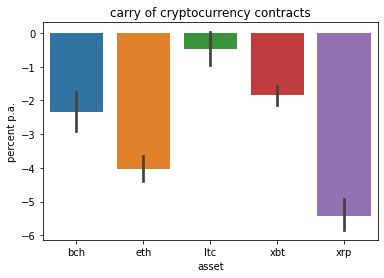

In [13]:
# plot
ax = sns.barplot(data=carry * ann * 100)
ax.set_title("carry of cryptocurrency contracts")
ax.set_ylabel("percent p.a.")

plt.show()

In [14]:
# print descriptives (some are meaningless)
carry_d = descriptives(carry, ann=ann, scl=100, cov_lags=30)

# print("carry of cryptocurrency contracts: descriptives\n")
# print(carry_d.iloc[:-2])
# print("-" * 41 + "\n")
# print("values are in percent p.a. where relevant.\n")
format_dataframe(carry_d, tail=False)

index,bch,eth,ltc,xbt,xrp
mean,-2.34,-4.02,-0.47,-1.84,-5.42
sterr,1.17,0.77,1.04,0.63,0.86
tstat,-2.00,-5.23,-0.45,-2.92,-6.29
median,-3.10,-3.23,-0.02,-0.74,-3.51
std,0.59,0.38,0.48,0.29,0.47
dstd,0.38,0.28,0.32,0.23,0.38
q95,34.73,21.66,35.67,17.32,23.13
q05,-39.58,-31.67,-33.68,-24.89,-42.07
skew,0.97,0.45,0.85,-0.13,-0.11
kurt,7.61,8.63,7.21,8.09,7.08


From this perspective, cryptocurrencies resemble fiat funding currencies such as JPY and EUR which also feature negative carry.

### portfolio construction

In [15]:
# the signal is the rolling median of the carry (proxy)
carry_sig = carry\
    .rolling(signal_lookback, min_periods=signal_lookback // 2)\
    .median()\
    .shift(1)

# below, 1 means that the asset is in portfolio at time t;
# portfolios are in the top level of the columns, while assets
# are in the bottom level
sorts = rank_sort(carry_sig, legsize=legsize)

format_dataframe(sorts[["p_low", "p_high"]])

/home/ipozdeev/projects/ippython/foolbox/backtesting/sorting.py:198: RuntimeWarning: invalid value encountered in true_divide
  bins = (np.array(nass)/n_assets+epsilon).cumsum()


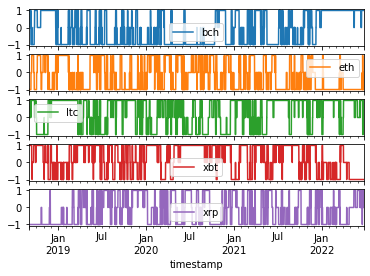

In [16]:
# plot positions
ax = sorts["p_high"].add(sorts["p_low"].mul(-1)).plot(subplots=True)

plt.show()

It can be seen that cryptocurrencies move between portfolios a lot &mdash; in stark contrast to fiat currencies in a typical fiat FX carry strategy, where the high and low portfolios are relatively stable.

### excess returns
Here, we implement the formulas in section ["return calculation"](#return-calculation). To keep the same leverage of 2 in the long and short leg, we use 1 long contract and 3 short ones.

In [17]:
# forward-looking returns and funding (levered x2)
# need 1 long and 3 short contracts to achieve the same level of leverage
n_long = 1
n_short = 3

# absolute funding rate
f_rate = data_f \
    .query("which == 'absolute'").drop("which", axis=1) \
    .pivot(index="timestamp", columns="asset", values="rate")

# long
r_long = n_long * data_s.shift(-t_hold) * \
     (1 / data_p - 1 / data_p.shift(-t_hold) -
      f_rate.shift(1).mul(4).rolling(t_hold).sum().shift(-t_hold + 1)) + \
     data_s.shift(-t_hold) / data_s - 1

# short
r_short = n_short * data_s.shift(-t_hold) * \
      (1 / data_p.shift(-t_hold) - 1 / data_p +
       f_rate.shift(1).mul(4).rolling(t_hold).sum().shift(-t_hold + 1)) + \
      data_s.shift(-t_hold) / data_s - 1

# both
rx = pd.concat([r_long, r_short], axis=1, keys=["p_high", "p_low"],
               names=["portfolio", "asset"])

print("excess returns, in percent")
format_dataframe(rx.dropna(how="all") * 100)

excess returns, in percent


In [18]:
# take a look at returns
print("p_high (x2 leverage):")
format_dataframe(descriptives(rx.xs("p_high", axis=1), ann=ann/t_hold, scl=100), tail=False)

p_high (x2 leverage):


index,bch,eth,ltc,xbt,xrp
mean,186.75,204.28,143.05,151.01,148.37
sterr,119.97,99.32,112.12,77.68,120.27
tstat,1.56,2.06,1.28,1.94,1.23
median,97.73,126.06,56.49,107.53,48.55
std,219.87,191.68,207.15,149.91,227.55
dstd,169.38,148.01,157.44,120.30,173.60
q95,15063.00,14214.64,14688.40,10823.98,14691.51
q05,-14397.81,-13434.51,-14190.84,-9938.34,-14418.82
skew,-0.05,-0.34,-0.28,-0.40,0.43
kurt,12.56,8.35,6.34,13.52,18.75


In [19]:
print("\np_low (x2 leverage):")
format_dataframe(descriptives(rx.xs("p_low", axis=1), ann=ann/t_hold, scl=100), tail=False)


p_low (x2 leverage):


index,bch,eth,ltc,xbt,xrp
mean,-139.50,-169.69,-114.13,-135.18,-102.42
sterr,123.28,100.38,113.26,78.93,122.22
tstat,-1.13,-1.69,-1.01,-1.71,-0.84
median,19.34,-45.63,-51.23,-93.72,-30.69
std,227.77,194.56,210.62,153.04,232.59
dstd,177.30,141.00,151.70,116.58,191.93
q95,14876.71,13487.38,14626.76,10248.80,14843.02
q05,-15305.83,-14452.19,-15179.01,-10986.09,-14884.87
skew,-0.02,0.37,0.30,0.50,-0.33
kurt,12.10,8.13,6.18,15.53,18.38


### carry trade performance

All currencies receive the same weight of 1/legsize if they are in the long, and -1/legsize or short portfolio. The excess return on a +1 long or -3 short position is calculated by dividing `sorts` which keeps 1.0s nad 0.0s through `legsize` and multiplying with the returns from the previous cell. The high-minus-low portfolio is the sum of the two (not the difference by the way the returns on short positions are calculated).

In [20]:
# sort returns into portfolios according to the signal
res_hl = rx.mul(sorts / legsize) \
    .groupby(axis=1, level="portfolio").sum(min_count=1) \
    .loc[:, ["p_high", "p_low"]].dropna()

# high minus low
res_hl.insert(0, "p_hml", res_hl.eval("p_high + p_low"))

format_dataframe(res_hl)

timestamp,p_hml,p_high,p_low
2022-03-31 04:00,0.01,0.00,0.01
2022-03-31 08:00,-0.00,0.00,-0.00
2022-03-31 12:00,0.05,-0.05,0.10
2022-03-31 16:00,0.01,0.01,0.00
2022-03-31 20:00,0.02,0.02,0.00


Let's calculate the descriptives and plot the cumulative returns.

In [21]:
# means, st err etc.
rx_d = descriptives(res_hl, ann=(ann / t_hold), scl=100)

format_dataframe(rx_d, tail=False)

index,p_hml,p_high,p_low
mean,175.14,217.75,-42.61
sterr,58.45,90.49,99.35
tstat,3.00,2.41,-0.43
median,171.78,87.18,0.00
std,114.27,175.44,190.63
dstd,88.66,142.65,133.66
q95,7534.00,12170.61,13198.35
q05,-7262.41,-11671.99,-13355.94
skew,0.42,-0.53,0.76
kurt,16.50,12.27,9.57


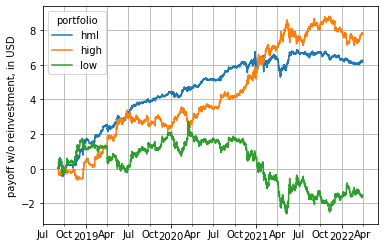

In [22]:
# plot
to_plot = res_hl.cumsum()\
    .rename(columns=lambda x: x[2:])\
    .reset_index().melt(id_vars=["timestamp"], value_name="payoff")
ax = sns.lineplot(x="timestamp", y="payoff", data=to_plot, hue="portfolio")

ax.xaxis.set_major_locator(YearLocator(1))
ax.xaxis.set_minor_locator(MonthLocator([1, 4, 7, 10]))
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
ax.xaxis.set_minor_formatter(DateFormatter("%b"))
ax.grid(True, which="both")

ax.set_xlabel("", visible=False)
ax.set_ylabel("payoff w/o reinvestment, in USD")

plt.show()

The long portfolio over- and the short one underperforms. The high-low strategy has earned about 600% return (w/o reinvestment) since end of september 2019, with a Sharpe ratio of 1.5.

</walkthrough>